# Evaluation functions
The evaluation functions operate on a pair of images, one with ground truth objects and one with the segmented objects. To test the functions, let's look at a simple case of a square and a circle overlaid on each other.

In [42]:
%run ../scripts/evaluation_functions.py

In [15]:
import rasterio as rio
from rasterio.plot import reshape_as_image
import proplot as pplt
import skimage as sk
import numpy as np

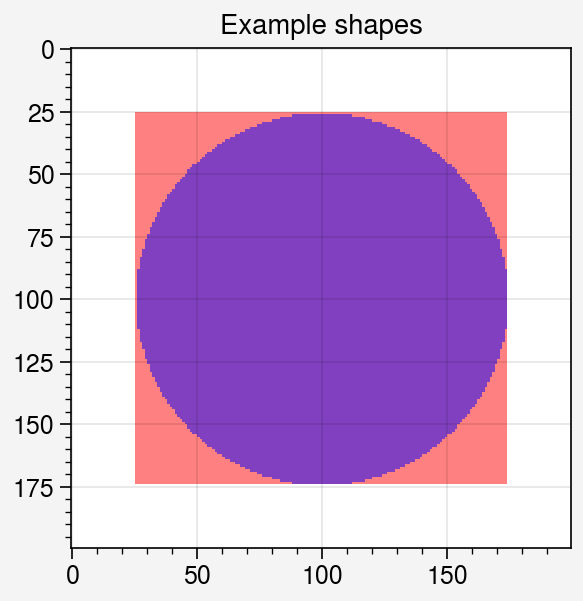

In [30]:
# Test with example shapes
im1 = np.zeros((200, 200))
im2 = im1.copy()
im1[25:175, 25:175] = 1
idx, jdx = np.meshgrid(range(200), range(200))
for ii in range(200):
    for jj in range(200):
        if np.sqrt((ii - 100)**2 + (jj - 100)**2) < 75:
            im2[ii, jj] = 1

fig, ax = pplt.subplots()
ax.imshow(np.ma.masked_array(im1, im1==0), alpha=0.5, c='r')
ax.imshow(np.ma.masked_array(im2, im2==0), alpha=0.5, c='b')
ax.format(title='Example shapes')

## Boundary measures
The dilated boundary F score and directed boundary F score are based on overlaps between expanded boundaries. In the dilated boundary F score, we use a disk shaped structuring element to dilate the boundary. In the directed boundary F score, a measure is computed a neighborhood centered on each pixel in the boundary.
Directed boundary F score:
$$  BF_{ij}(r) = \frac{1}{|\partial g_i|}\sum_{x \in \partial g_i} \frac{2|g_i \cap s_j \cap N_r(x)|}{|g_i \cap N_r(x)| + |s_j \cap N_r(x)|}  $$
Dilated boundary F score:
$$     BFD_{ij} = F_{ij}(\partial g_i \oplus \epsilon_r, \partial_{sj} \oplus \epsilon_r) $$
where $F$ is 
    $$ F = 2 \frac{Pr \cdot Re}{Pr + Re} = 2\frac{|G \cap S|}{|G| + |S|} $$

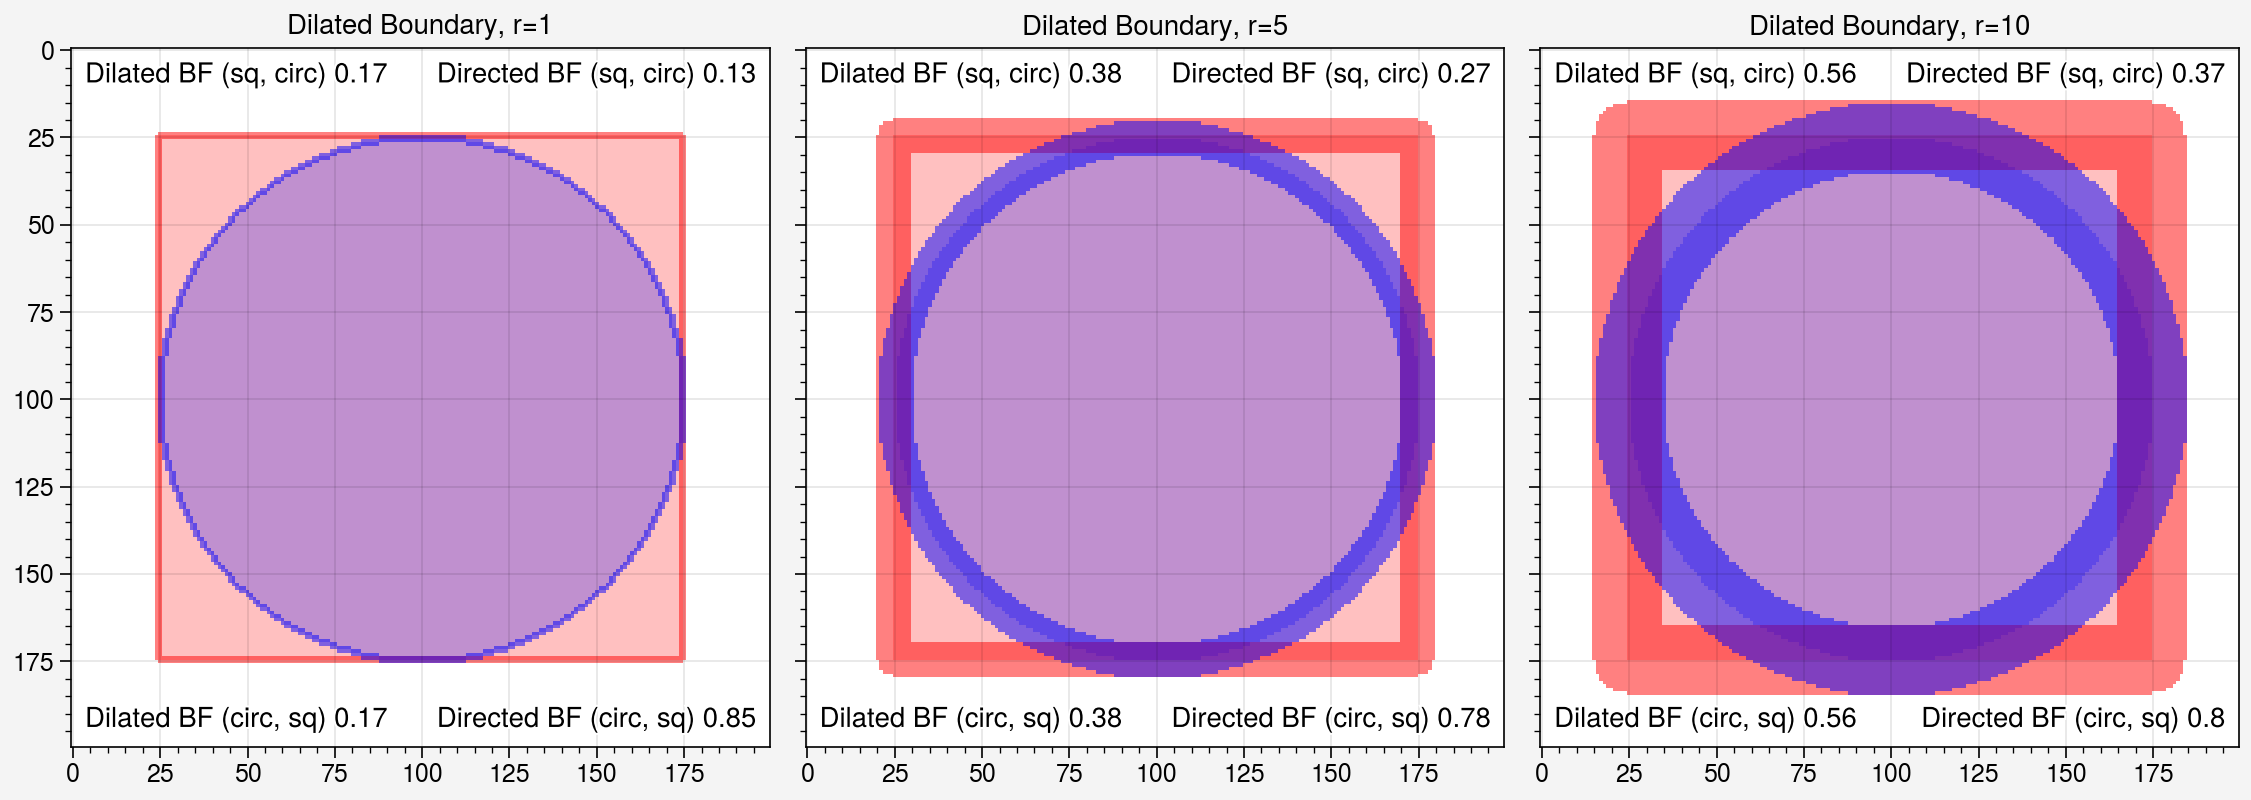

In [45]:
fig, axs = pplt.subplots(height=4, ncols=3)
for ax, r in zip(axs, [1, 5, 10]):
    ax.imshow(np.ma.masked_array(im1, im1==0), alpha=0.25, c='r')
    ax.imshow(np.ma.masked_array(im2, im2==0), alpha=0.25, c='b')

    
    k = sk.morphology.disk(r)
    im1_bdry = sk.morphology.dilation(im1, k) - sk.morphology.erosion(im1, k)
    im2_bdry = sk.morphology.dilation(im2, k) - sk.morphology.erosion(im2, k)
    
    ax.imshow(np.ma.masked_array(im1_bdry, im1_bdry==0), alpha=0.5, c='r')
    ax.imshow(np.ma.masked_array(im2_bdry, im2_bdry==0), alpha=0.5, c='b')
    ax.format(title='Dilated Boundary, r=' + str(r))

    bf_dil = bdry_dil_f_score(1, 1, im1, im2, radius=r)
    bf_dir = bdry_dir_f_score(1, 1, im1, im2, radius=r)
    ax.format(ultitle='Dilated BF (sq, circ) ' + str(np.round(bf_dil, 2)),
              urtitle='Directed BF (sq, circ) ' + str(np.round(bf_dir, 2)))
    bf_dil = bdry_dil_f_score(1, 1, im2, im1, radius=r)
    bf_dir = bdry_dir_f_score(1, 1, im2, im1, radius=r)
    ax.format(lltitle='Dilated BF (circ, sq) ' + str(np.round(bf_dil, 2)),
              lrtitle='Directed BF (circ, sq) ' + str(np.round(bf_dir, 2)))

We can see that the dilated BF is symmetric -- it doesn't matter what order we place the shapes in the equation. The directed BF is not (hence the name). The dilated measure is strongly dependent on the size of the radius, while the directed method is only weakly dependent. We see a strong difference in the forward and backward versions of the measure.

TBD: rewrite the directed boundary function to be more robust to edges, by using the meshgrid approach. Or using something that identifies negative indices.

In [ ]:
dataloc = '../data/validation_images/binary_floes/'
examp_img = '121-greenland_sea-20120406-terra-binary_floes.png'
img1 = rio.open(dataloc + examp_img)
img2 = rio.open(dataloc + examp_img.replace('terra', 'aqua'))

img1 = reshape_as_image(img1.read())
img2 = reshape_as_image(img2.read())[::-1,:,:]

/opt/homebrew/Caskroom/miniconda/base/envs/eval_seg/lib/python3.9/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
sk.morphology.dilation

/opt/homebrew/Caskroom/miniconda/base/envs/eval_seg/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


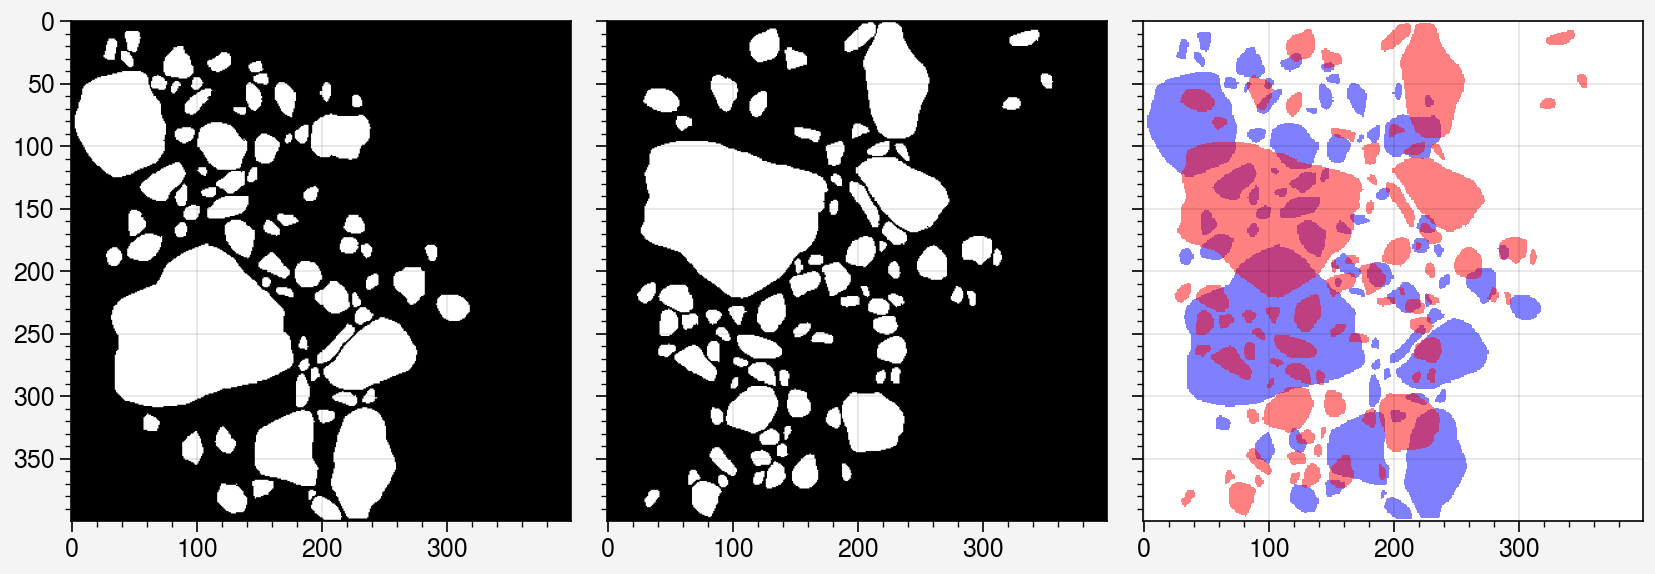

In [6]:
fig, ax = pplt.subplots(ncols=3)
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(np.ma.masked_array(img1[:,:,0], img1[:,:,0]==0), c='b', alpha=0.5)
ax[2].imshow(np.ma.masked_array(img2[:,:,0], img2[:,:,0]==0), c='r', alpha=0.5)

We'll treat the second image as a segmentation result just for illustration purposes. We first need to label the images.

In [7]:
lb_img1 = skimage.measure.label(img1[:,:, 0])
lb_img2 = skimage.measure.label(img2[:,:,0])

In [8]:
%run ../scripts/evaluation_functions.py
df_measures = compute_metrics(lb_img1, lb_img2, return_type='unweighted')
df_measures

label_i                           41.249573
area_i                          5730.555556
area_j                           612.600000
overlap                          153.458974
area_relative_error               -3.471052
area_similarity_ratio              0.160558
normalized_area_diff_ratio         0.777080
undersegmentation_error            0.264334
oversegmentation_error             0.774891
segmentation_error                 0.851662
euclidean_distance                22.937808
hausdorff_distance                58.131510
modified_hausdorff_distance       26.461011
shape_dissimilarity                5.020833
directed_boundary_dice_score       0.165591
n                                 45.000000
dtype: float64

In [9]:
compute_metrics(lb_img1, lb_img2, return_type='weighted')

label_i                            40.653848
area_i                          12005.936258
area_j                            232.833764
overlap                           207.605018
area_relative_error                 0.842757
area_similarity_ratio               0.028231
normalized_area_diff_ratio          0.949946
undersegmentation_error             0.046539
oversegmentation_error              0.973198
segmentation_error                  0.955621
euclidean_distance                 35.609873
hausdorff_distance                 96.385681
modified_hausdorff_distance        45.146242
shape_dissimilarity                 1.103640
directed_boundary_dice_score        0.011386
n                                  45.000000
dtype: float64

In [ ]:
select_relevant_set(1, 

In [10]:
import sklearn
error, precision, recall = skimage.metrics.adapted_rand_error(lb_img1, lb_img2)
splits, merges = skimage.metrics.variation_of_information(lb_img1, lb_img2)
splits, merges

(1.4087041712407433, 1.5482432832100737)

In [11]:
df_measures_unwtd = df_measures.groupby('label_i').mean()
df_measures_unwtd['n'] = df_measures.groupby('label_i').count()['label_j']

KeyError: 'label_i'

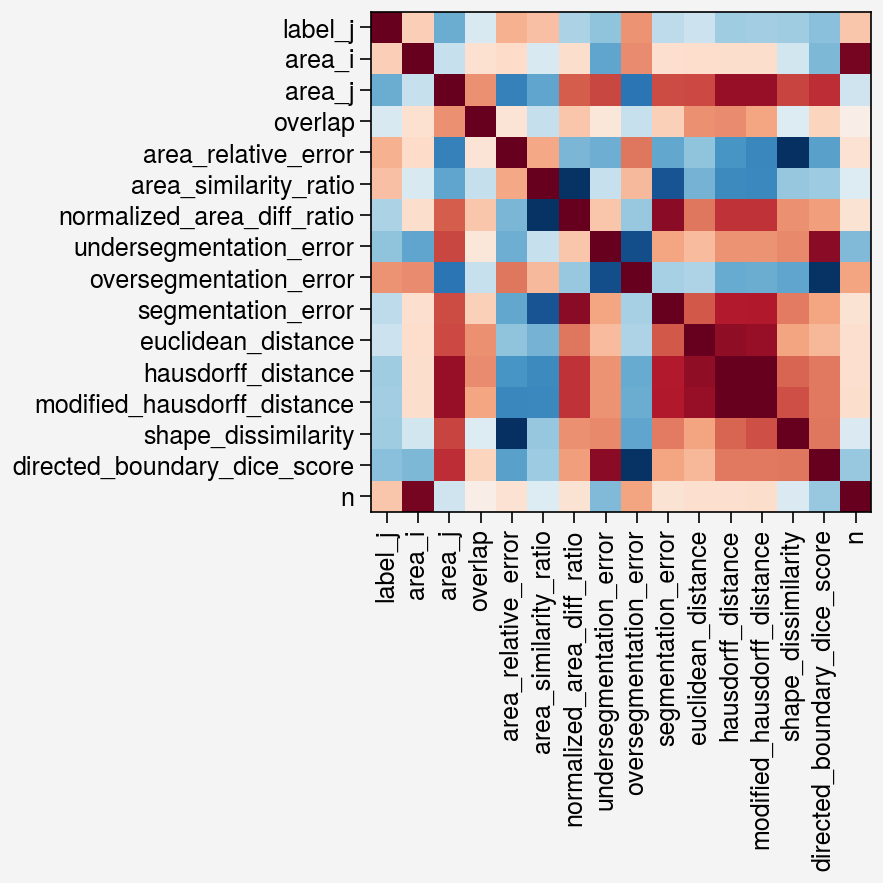

In [65]:
fig, ax = pplt.subplots()
ax.heatmap(df_measures_unwtd.corr())
ax.format(xrotation=90, xreverse=False, yreverse=True)